In [1]:
# Imports
import pandas as pd
pd.set_option('display.max_columns', 50)
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import sklearn

In [2]:
# Import data from drive
from google.colab import drive
drive.mount("/content/drive/")
%cd drive/MyDrive/SPRING_2023_IW/

Mounted at /content/drive/
/content/drive/MyDrive/SPRING_2023_IW


In [3]:
# directory debugging code
%cd .
%ls

/content/drive/MyDrive/SPRING_2023_IW
COS398_IW.ipynb  database.sqlite  git.ipynb  README.md


In [4]:
# Create DB conn and pandas dataframes of tables
conn = sqlite3.connect("database.sqlite")
player_df = pd.read_sql_query("SELECT * FROM Player", conn)
player_attributes_df = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
team_df = pd.read_sql_query("SELECT * FROM Team", conn)
team_attributes_df = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)
match_df = pd.read_sql_query("SELECT * FROM Match", conn)
league_df = pd.read_sql_query("SELECT * FROM League", conn)
country_df = pd.read_sql_query("SELECT * FROM Country", conn)

In [5]:
# Df column labels
match_df_labels = [
  'id', 'country_id', 'league_id', 'season', 'date', 'home_team_api_id',
  'away_team_api_id', 'home_player_1', 'home_player_2', 'home_player_3',
  'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
  'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
  'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
  'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
  'away_player_9', 'away_player_10', 'away_player_11'
]

player_attributes_df_labels = [
  'player_api_id', 'date', 'overall_rating', 'potential',
  'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing',
  'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
  'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration',
  'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping',
  'stamina', 'strength', 'long_shots', 'aggression', 'interceptions',
  'positioning', 'vision', 'penalties', 'marking', 'standing_tackle',
  'sliding_tackle'
]

team_attributes_df_labels = [
  'team_api_id', 'date', 'buildUpPlaySpeed', 'buildUpPlayDribbling', 
  'buildUpPlayPassing', 'buildUpPlayPositioningClass', 'chanceCreationPassing',
  'chanceCreationCrossing', 'chanceCreationShooting', 'chanceCreationPositioningClass',
  'defencePressure', 'defenceAggression', 'defenceTeamWidth', 'defenceDefenderLineClass'
]

In [6]:
# Basic data cleaning (removing missing vals, using only 2015-16 season)
# Only get cols we could possibly care about
match_df = match_df[match_df_labels].copy()
player_attributes_df = player_attributes_df[player_attributes_df_labels].copy()
team_attributes_df = team_attributes_df[team_attributes_df_labels].copy()
team_df.drop(labels=["team_fifa_api_id"], axis=1)

# Remove rows with missing values
player_df.dropna(inplace=True)
player_attributes_df.dropna(inplace=True) # drops 2713 rows, investigate which players and what year?
# team_df.dropna(inplace=True) (only fifa id missing, we don't care)
team_attributes_df.dropna(inplace=True) # drops some buildUpPlayDribbling
match_df.dropna(inplace=True)
league_df.dropna(inplace=True)
country_df.dropna(inplace=True)

# Only use match data from the 2015-16 season
match_df = match_df[match_df.season.str.contains("2015/2016")].copy()

# Using match data, for each league, get its start date and end date for the 2015-16 season
season_min = match_df['date'].min(axis=0)
season_max = match_df['date'].max(axis=0)
print(f"Season min: {season_min}")
print(f"Season max: {season_max}\n")

# Only use player data from the 2015-16 season, keeping only the latest data point
player_attributes_df = player_attributes_df[
  (player_attributes_df['date'] >= season_min) & (player_attributes_df['date'] <= season_max)
].copy()
player_attributes_df.drop_duplicates(subset=['player_api_id'], keep='last', inplace=True)

# Only use team data from the 2015-16 season, keeping only the latest data point
### In combination with dropping missing buildUpPlayDribbling, this only uses data from 2014 onwards, get 5 teams from 2014
# team_attributes_df = team_attributes_df[
#   (team_attributes_df['date'] >= season_min) & (team_attributes_df['date'] <= season_max)
# ].copy()
team_attributes_df.drop_duplicates(subset=['team_api_id'], keep='last', inplace=True)

Season min: 2015-07-17 00:00:00
Season max: 2016-05-25 00:00:00



In [7]:
### Exploratory Data Analysis
# Merge the home and away teams from match_df on team_df
home_team_df = match_df.merge(team_df, how="inner", left_on='home_team_api_id', right_on='team_api_id')
away_team_df = match_df.merge(team_df, how="inner", left_on='away_team_api_id', right_on='team_api_id')

# Create a combined team df (matches + teams)
combined_team_df = pd.concat([home_team_df, away_team_df])
combined_team_df_nodups = combined_team_df.drop_duplicates(subset=['team_api_id'])
print(f"Combined_team_df shape: {combined_team_df.shape}")
print(f"Combined_team_df_nodups shape: {combined_team_df_nodups.shape}")

Combined_team_df shape: (6036, 34)
Combined_team_df_nodups shape: (188, 34)


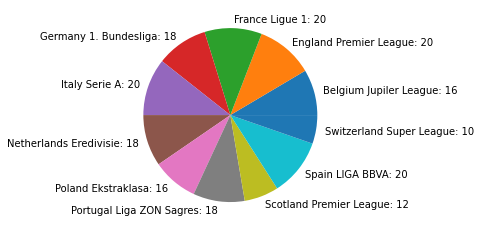

In [8]:
# Create a pie chart showing what leagues the teams played in
team_leagues_df = combined_team_df_nodups.merge(league_df, how="inner", left_on="league_id", right_on="id")
league_dict = {}
league_labels = []
league_sizes = []
for _, row in team_leagues_df.iterrows():
  league_name = row["name"]
  if league_name not in league_dict:
    league_dict[league_name] = 1
  else:
    league_dict[league_name] += 1
for label in league_dict:
  league_labels.append(label + ": " + str(league_dict[label]))
  league_sizes.append(league_dict[label])
fig, ax = plt.subplots()
ax.pie(league_sizes, labels=league_labels)
plt.show()

In [9]:
# Compile a list of players that played for each team during the 2015-16 season
team_league_df = combined_team_df.merge(league_df, how="inner", left_on="league_id", right_on="id")
team_dict = {} # Key: team_api_id, Value: info_dict
# print(team_league_df)

home_player_labels = [
  'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
  'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
  'home_player_9', 'home_player_10', 'home_player_11'
]
away_player_labels = [
  'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
  'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
  'away_player_9', 'away_player_10', 'away_player_11'
]

for _, row in team_league_df.iterrows():
  team_api_id = row['team_api_id']
  # For an unseen team, construct a team_info_dict
  if team_api_id not in team_dict:
    team_info_dict = {
        'team_short_name': row['team_short_name'],
        'team_long_name': row['team_long_name'],
        'league': row['name'],
        'player_info_dict': {} # Key: player_api_id, # Value: player_info_dict
    }
    team_dict[team_api_id] = team_info_dict
  # Add home or away players, depending on which we looked at
  if team_api_id == row['home_team_api_id']:
    for home_player_label in home_player_labels:
      home_player_id = row[home_player_label]
      if home_player_id not in team_dict[team_api_id]['player_info_dict']:
        team_dict[team_api_id]['player_info_dict'][home_player_id] = {}

  elif team_api_id == row['away_team_api_id']:
    for away_player_label in away_player_labels:
      away_player_id = row[away_player_label]
      if away_player_id not in team_dict[team_api_id]['player_info_dict']:
        team_dict[team_api_id]['player_info_dict'][away_player_id] = {}
  else:
    print("ERROR! team_api_id doesn't match home or away!")
  
# Populate the player_info_dict for each player id
for team in team_dict:
  player_info_dict = team_dict[team]['player_info_dict']
  for player_api_id in player_info_dict:
    row = player_attributes_df[player_attributes_df['player_api_id'] == player_api_id]
    if row is None:
      print("ERROR! player attribute row is None!")
    # Add row information to player_info_dict
    player_info_dict[player_api_id] = {
      label: row[label] for label in player_attributes_df_labels
    }

In [10]:
# Calculate how many players belong to each team, and some stats about the distribution
team_player_count_dict = {} # Key: team_long_name, # Value: Player count
team_player_count_list = []
for team in team_dict:
  count = len(team_dict[team]['player_info_dict'])
  team_player_count_dict[team_dict[team]['team_long_name']] = count
  team_player_count_list.append(count)
# print(team_player_count_dict)

print("Summary stats of # of players on every team:")
print(pd.Series(team_player_count_list).describe())
print("\n")

# And see the distribution within each league!
team_league_player_count_dict = {} # Key: league, Value: {} # Key: team_long_name, Value: count
team_league_player_count_list = {} # Key: league, Value: list of player counts
for team in team_dict:
  team_info_dict = team_dict[team]
  league = team_info_dict['league']
  if league in team_league_player_count_dict:
    team_league_player_count_dict[league][team_info_dict['team_long_name']] = len(team_info_dict['player_info_dict'])
  else:
    team_league_player_count_dict[league] = {
      team_info_dict['team_long_name']: len(team_info_dict['player_info_dict'])
    }
for league in team_league_player_count_dict:
  league_count_list = []
  for team_long_name in team_league_player_count_dict[league]:
    league_count_list.append(team_player_count_dict[team_long_name])
  team_league_player_count_list[league] = league_count_list

# print(team_league_player_count_dict)

for league in team_league_player_count_dict:
  print(f"Summary stats of {league}:")
  # print(pd.Series(team_league_player_count_list[league]).describe())
  # print("\n")



Summary stats of # of players on every team:
count    188.000000
mean      25.042553
std        3.103956
min       17.000000
25%       23.000000
50%       25.000000
75%       27.000000
max       33.000000
dtype: float64


Summary stats of Belgium Jupiler League:
Summary stats of England Premier League:
Summary stats of France Ligue 1:
Summary stats of Germany 1. Bundesliga:
Summary stats of Italy Serie A:
Summary stats of Netherlands Eredivisie:
Summary stats of Poland Ekstraklasa:
Summary stats of Portugal Liga ZON Sagres:
Summary stats of Scotland Premier League:
Summary stats of Spain LIGA BBVA:
Summary stats of Switzerland Super League:


In [11]:
## DATA PREPARATION BASED ON 2015-16 data

# Filter team_attributes data based on teams that played in the 2015-16 season
team_attributes_df = team_attributes_df[team_attributes_df['team_api_id'].isin(team_dict)]

# Filter player_attributes data based on players on teams that played in the 2015-16 season
player_api_ids = []
for team in team_dict:
  player_info_dict = team_dict[team]['player_info_dict']
  for player_api_id in player_info_dict:
    player_api_ids.append(player_api_id)
player_attributes_df = player_attributes_df[player_attributes_df['player_api_id'].isin(player_api_ids)]

In [12]:
# If data has been prepared, don't run again
player_work_rate_converted = False
team_buildup_class_converted = False
team_chance_class_converted = False
team_defence_class_converted = False

player_date_id_dropped = False
team_date_id_dropped = False

standardized = False

In [13]:
# Data preparation

# Player_attributes categorical features:
# convert attacking_work_rate and defensive_work_rate into numerical features
# 'low' = 17, 'medium' = 50, '83' = high
if not player_work_rate_converted:
  work_rate_dict = {
      'low': 17,
      'medium': 50,
      'high': 83
  }
  player_attributes_df['attacking_work_rate'] = player_attributes_df['attacking_work_rate'].map(work_rate_dict)
  player_attributes_df['defensive_work_rate'] = player_attributes_df['defensive_work_rate'].map(work_rate_dict)
  player_work_rate_converted = True

# Team_attributes categorical features:
# convert buildUpPlayPositioningClass: 'Organised' = 1, 'Free Form' = 0
# convert chanceCreationPositioningClass: 'Organised' = 1, 'Free Form' = 0
# convert defenceDefenderLineClass: 'Cover' = 1, 'Offside Trap' = 0
if not team_buildup_class_converted:
  buildup_dict = {
    'Organised': 1,
    'Free Form': 0
  }
  team_attributes_df['buildUpPlayPositioningClass'] = team_attributes_df['buildUpPlayPositioningClass'].map(buildup_dict)
  team_buildup_class_converted = True
if not team_chance_class_converted:
  chance_dict = {
    'Organised': 1,
    'Free Form': 0
  }
  team_attributes_df['chanceCreationPositioningClass'] = team_attributes_df['chanceCreationPositioningClass'].map(buildup_dict)
  team_chance_class_converted = True
if not team_defence_class_converted:
  defense_dict = {
    'Cover': 1,
    'Offside Trap': 0
  }
  team_attributes_df['defenceDefenderLineClass'] = team_attributes_df['defenceDefenderLineClass'].map(defense_dict)
  team_defence_class_converted = True


<ipython-input-13-1a666333f8b8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_attributes_df['attacking_work_rate'] = player_attributes_df['attacking_work_rate'].map(work_rate_dict)
<ipython-input-13-1a666333f8b8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_attributes_df['defensive_work_rate'] = player_attributes_df['defensive_work_rate'].map(work_rate_dict)
<ipython-input-13-1a666333f8b8>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [14]:
# VISUALIZE BEFORE DATA
# print(player_attributes_df)
# print(team_attributes_df)

In [15]:
# Basic feature selection: remove cols that aren't numerical features or have low variance (just date I guess)
if not player_date_id_dropped:
  player_attributes_df.drop(columns=['date'], inplace=True)
  player_date_id_dropped = True

if not team_date_id_dropped:
  team_attributes_df.drop(columns=['date'], inplace=True)
  team_date_id_dropped = True

<ipython-input-15-f72f06666e59>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_attributes_df.drop(columns=['date'], inplace=True)
<ipython-input-15-f72f06666e59>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_attributes_df.drop(columns=['date'], inplace=True)


In [16]:
# standardization (except player_api_id)
if not standardized:
  player_attributes_df_labels.remove('date')
  player_attributes_df_labels.remove('player_api_id')
  player_attributes_df[player_attributes_df_labels] = player_attributes_df[player_attributes_df_labels].apply(
      lambda x: (x - x.mean()) / x.std()
  )
  team_attributes_df_labels.remove('date')
  team_attributes_df_labels.remove('team_api_id')
  team_attributes_df[team_attributes_df_labels] = team_attributes_df[team_attributes_df_labels].apply(
      lambda x: (x - x.mean()) / x.std()
  )
  standardized = True

In [17]:
# Dimensions of data:
print(f"Player_df shape: {player_df.shape}")
print(f"Player_attributes_df shape: {player_attributes_df.shape}")
print(f"Team_df shape: {team_df.shape}")
print(f"Team_attributes_df shape: {team_attributes_df.shape}") # Missing 7 teams, but not much we can do
print(f"Match_df shape: {match_df.shape}")
print(f"League_df shape: {league_df.shape}")
print(f"Country_df shape: {country_df.shape}\n")

Player_df shape: (11060, 7)
Player_attributes_df shape: (4500, 33)
Team_df shape: (299, 5)
Team_attributes_df shape: (181, 13)
Match_df shape: (3018, 29)
League_df shape: (11, 3)
Country_df shape: (11, 2)



<Axes: >

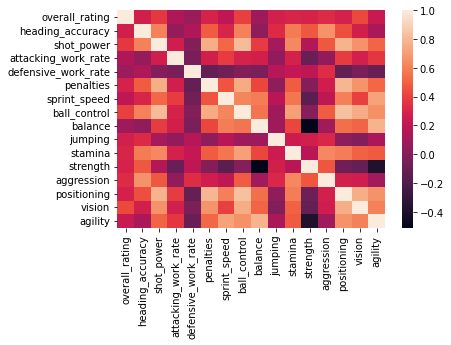

In [18]:
# Heatmap on player attributes
sns.heatmap(player_attributes_df[[
    'overall_rating', 'heading_accuracy', 'shot_power', 'attacking_work_rate', 'defensive_work_rate', 'penalties',
    'sprint_speed', 'ball_control', 'balance', 'jumping', 'stamina', 'strength',
  'aggression', 'positioning', 'vision', 'agility']].corr())

<Axes: >

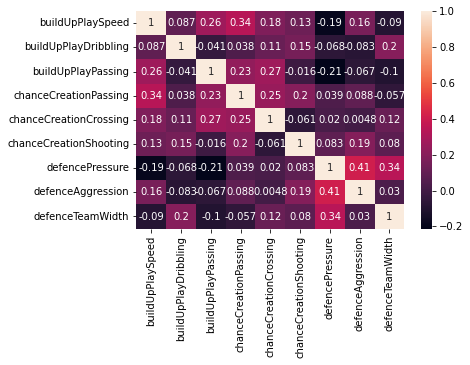

In [19]:
# Heatmap on team attributes
sns.heatmap(team_attributes_df[[
    'buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 'chanceCreationPassing',
    'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure', 'defenceAggression',
    'defenceTeamWidth'
]].corr(), annot=True)

In [33]:
# Final data preparation

# For each team, construct a vector with mean and stddev of each feature
# Features specified in labels
def construct_player_df(team_dict, player_attributes_df, labels):
  player_df = pd.DataFrame({})

  for team_api_id in team_dict:
    data = {}
    player_dict = team_dict[team_api_id]['player_info_dict']
    player_attributes_team_df = player_attributes_df[player_attributes_df['player_api_id'].isin(player_dict)]
    for label in labels:
      colObj = player_attributes_team_df[label]
      data[label] = colObj.mean()
      # data[label + '_stddev'] = colObj.std() # don't consider stddev of attributes
    df = pd.DataFrame(data, index=[team_api_id])
    player_df = pd.concat([player_df, df])
  
  return player_df

# For each team, construct a feature vector, where features are specified in labels
def construct_team_df(team_attributes_df, labels):
  team_df = pd.DataFrame({})

  for _, row in team_attributes_df.iterrows():
    team_api_id = row['team_api_id']
    data = {}
    for label in labels:
      data[label] = row[label]
    df = pd.DataFrame(data, index=[team_api_id])
    team_df = pd.concat([team_df, df])

  return team_df

In [34]:
TEAM_LABELS_BEFORE = [
  'buildUpPlaySpeed', 'buildUpPlayDribbling', 
  'buildUpPlayPassing', 'buildUpPlayPositioningClass', 'chanceCreationPassing',
  'chanceCreationCrossing', 'chanceCreationShooting', 'chanceCreationPositioningClass',
  'defencePressure', 'defenceAggression', 'defenceTeamWidth', 'defenceDefenderLineClass'
]

TEAM_LABELS_AFTER = [
  'buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
  'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
  'defencePressure', 'defenceAggression', 'defenceTeamWidth'
]

PLAYER_LABELS_BEFORE = [
  'overall_rating', 'potential', 'attacking_work_rate', 'defensive_work_rate', 
  'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 
  'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 
  'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 
  'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions',
  'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle'
]

PLAYER_LABELS_AFTER = [
  'overall_rating', 'attacking_work_rate', 'defensive_work_rate',
  'heading_accuracy', 'ball_control', 'sprint_speed', 'agility', 'balance', 
  'shot_power', 'jumping', 'stamina', 'strength', 'aggression',
  'positioning', 'vision', 'penalties'
]

# PLAYER_LABELS_AFTER_FULL = []
# for label in PLAYER_LABELS_AFTER:
#   PLAYER_LABELS_AFTER_FULL.append(label)
#   PLAYER_LABELS_AFTER_FULL.append(label + '_std')

player_df_before = construct_player_df(team_dict, player_attributes_df, PLAYER_LABELS_BEFORE)
player_df_after = construct_player_df(team_dict, player_attributes_df, PLAYER_LABELS_AFTER)
team_df_before = construct_team_df(team_attributes_df, TEAM_LABELS_BEFORE)
team_df_after = construct_team_df(team_attributes_df, TEAM_LABELS_AFTER)

In [35]:
# VISUALIZE PROCESSED DATA
print(player_df_after)
print(team_df_after)

       overall_rating  attacking_work_rate  defensive_work_rate  \
9997        -0.728874             0.197248             0.025811   
8571        -0.534369            -0.276466             0.188448   
9987        -0.105498             0.071987             0.047898   
8573        -0.150820            -0.145572            -0.068347   
10000       -0.497089            -0.047011            -0.007318   
...               ...                  ...                  ...   
10190       -1.101924            -0.153483            -0.096514   
9824        -1.363362            -0.228639            -0.020061   
10192       -0.547835            -0.153483            -0.020061   
10179       -0.614765             0.249357            -0.331990   
7896        -1.485469            -0.114271            -0.432244   

       heading_accuracy  ball_control  sprint_speed   agility   balance  \
9997          -0.298215     -0.177829      0.194509  0.301858  0.211524   
8571          -0.010982     -0.047270     -0.

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

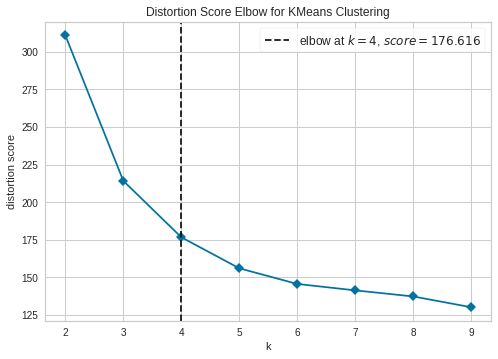

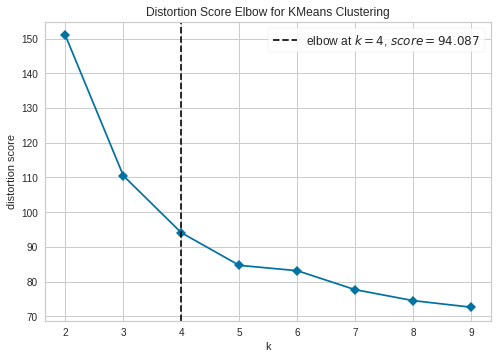

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [49]:
# Naive clustering and evaluation before and after heatmap feature selection (players)
# Before
km = KMeans(random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10), timings=False)
visualizer.fit(player_df_before.values)
visualizer.show()

# After
km = KMeans(random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10), timings=False)
visualizer.fit(player_df_after.values)
visualizer.show()

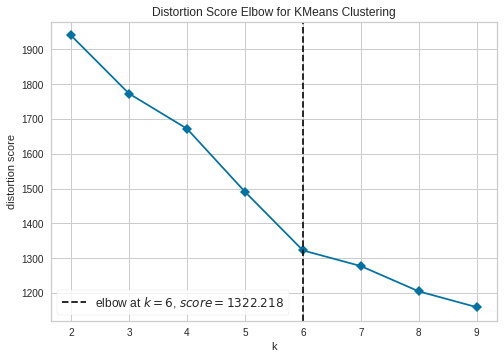

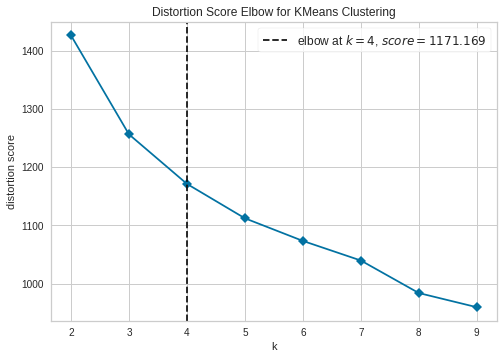

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
# Naive clustering and evaluation before and after heatmap (teams)
km = KMeans(random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10), timings=False)
visualizer.fit(team_df_before.values)
visualizer.show()

km = KMeans(random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10), timings=False)
visualizer.fit(team_df_after.values)
visualizer.show()

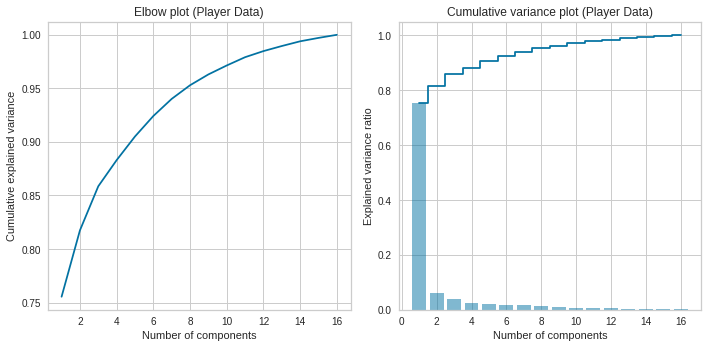

In [46]:
# PCA for player data; selecting # of components
n_components = range(1, 17)
pca = PCA(n_components=max(n_components))
pca.fit(player_df_after.values)

# Elbow plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(n_components, np.cumsum(pca.explained_variance_ratio_[:len(n_components)]))
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Cumulative explained variance')
ax[0].set_title('Elbow plot (Player Data)')

# Cumulative variance plot
ax[1].bar(n_components, pca.explained_variance_ratio_, alpha=0.5, align='center')
ax[1].step(n_components, np.cumsum(pca.explained_variance_ratio_), where='mid')
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Explained variance ratio')
ax[1].set_title('Cumulative variance plot (Player Data)')

plt.tight_layout()
plt.show()

# We see an elbow at 3 components, which captures >0.85 cumulative variance

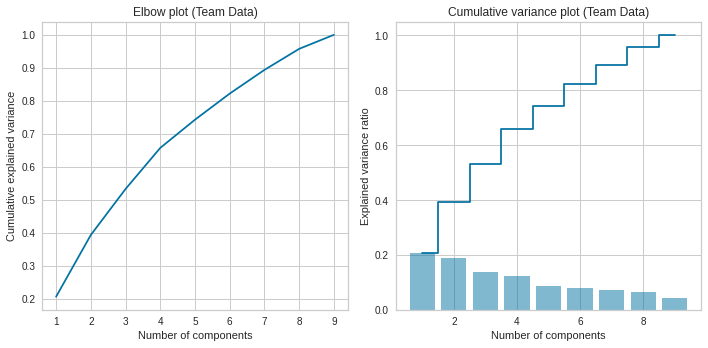

In [47]:
# PCA for team data; selecting # of components
n_components = range(1, 10)
pca = PCA(n_components=max(n_components))
pca.fit(team_df_after.values)

# Elbow plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(n_components, np.cumsum(pca.explained_variance_ratio_[:len(n_components)]))
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Cumulative explained variance')
ax[0].set_title('Elbow plot (Team Data)')

# Cumulative variance plot
ax[1].bar(n_components, pca.explained_variance_ratio_, alpha=0.5, align='center')
ax[1].step(n_components, np.cumsum(pca.explained_variance_ratio_), where='mid')
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Explained variance ratio')
ax[1].set_title('Cumulative variance plot (Team Data)')

plt.tight_layout()
plt.show()

# Each component contributes significantly to the variance, so we might as well just not use PCA

In [48]:
# visualize PCA
pca = PCA(n_components=3)
pca.fit(player_df_after.values)
components = pca.components_
feature_names = PLAYER_LABELS_AFTER
component_names = ['PC{}'.format(i+1) for i in range(len(components))]
weights_df = pd.DataFrame(components, columns=feature_names, index=component_names)

# Extract the eigenvalues of the principal components
eigenvalues = pca.explained_variance_

# Display the top features and their corresponding weights as a table
for i, pc in enumerate(component_names):
    sorted_weights = weights_df.loc[pc].abs().sort_values(ascending=False)
    top_weights = sorted_weights
    top_weights_names = top_weights.index.tolist()
    top_weights_values = top_weights.values.tolist()
    df = pd.DataFrame({'Feature': top_weights_names, 'Weight': top_weights_values})
    df.index += 1
    df.index.name = 'Rank'
    df.insert(0, 'PC', [pc] * len(df))
    print('Top features for {}:'.format(pc))
    print(df)

Top features for PC1:
       PC              Feature    Weight
Rank                                    
1     PC1       overall_rating  0.657386
2     PC1         ball_control  0.290137
3     PC1               vision  0.286906
4     PC1           shot_power  0.258417
5     PC1            penalties  0.215001
6     PC1           aggression  0.211171
7     PC1          positioning  0.206786
8     PC1              stamina  0.190380
9     PC1     heading_accuracy  0.182098
10    PC1         sprint_speed  0.174747
11    PC1              agility  0.167126
12    PC1              jumping  0.163452
13    PC1             strength  0.150971
14    PC1  attacking_work_rate  0.122398
15    PC1              balance  0.073918
16    PC1  defensive_work_rate  0.056259
Top features for PC2:
       PC              Feature    Weight
Rank                                    
1     PC2             strength  0.496378
2     PC2              balance  0.434365
3     PC2              agility  0.397701
4     PC2    

# PC1: Well-rounded players who have good ball control and shooting
# PC2: Physical, strong players
# PC3: Tall, defense-focused players

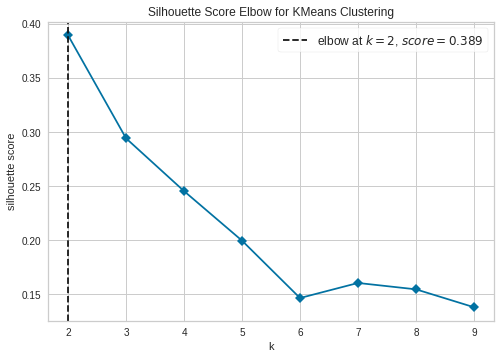

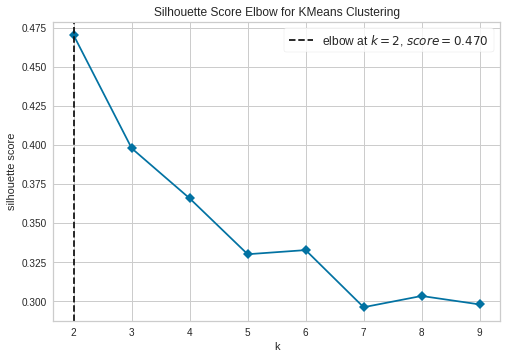

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [52]:
# Naive clustering and evaluation before and after PCA (players)
km = KMeans(random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, metric="silhouette", k=(2,10), timings=False)
visualizer.fit(player_df_after.values)
visualizer.show()

km = KMeans(random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, metric="silhouette", k=(2,10), timings=False)
# Apply PCA transformation to player data
player_df_pca = pca.transform(player_df_after.values)
visualizer.fit(player_df_pca)
visualizer.show()

## WEEK OF 3/19: Model Fitting/Evaluation

In [ ]:
# Model Fitting
# 

In [ ]:
# Data preparation
  # labels vectors on categorical features?
  # most FIFA attributes are already scaled; 1-99 scores, but all features have different distributions, standardiation would be helpful

# Select relevant features and dive into those
  # Heatmap on all attributes (with an attribute?) (what correlates strongly/negatively with that attribute)
  # Online articles on EDA and more stuff to do (use seaborn for nice graphs)

# Feature selection:
  # try diff. models with varying amount of data?
  # Try comparing attributes in diff. categories
  # Clustering on subsets of relevant columns
  # Reduce data to important features: Think about the main goal here!! what is the question you're trying to accomplish? Player stats/playstyles specifically! 
    # Do soccer research on relevant stats/attributes (for both players and teams)
    # Really trying to look at: playstyles, and what features are the most important for building teams

# Once features are selected, do final data preparation by preparing player features per team

# PCA

# Do a naive clustering comparison of data before PCA and after PCA
# tune hyperparameters and evaluate on a couple metrics

# Model fitting
  # K-means clustering
  # Hierarchical clustering
  # GMM

# Evaluation


# Analysis